In [1]:
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional  as F

In [4]:
import scipy.stats as stats

## 1. Create the dataset

In [5]:
nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack( (  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                         1+np.ones( (nPerClust))  ) )

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()

# note: "long" format for CCE :Multiclass classification
labels = torch.tensor(labels_np).long()    

## 2. Data Visualization

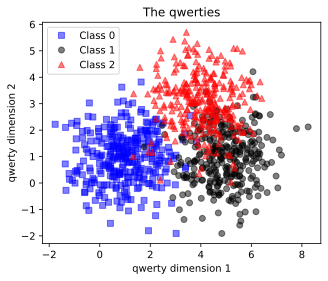

In [6]:
# show the data
fig = plt.figure(figsize=(5,4) ,dpi = 140)

plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',
         alpha=.5 , label = "Class 0")
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',
         alpha=.5 ,label = "Class 1")
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',
         alpha=.5 ,label = "Class 2")

plt.title('The qwerties')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.legend()
plt.show()

## 3. Convert the Data into Tensor Dataset

In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [8]:
# scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

# convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects

batchsize    = 16 
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True  ,drop_last=True)
test_loader  = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0] ) 

In [9]:
len(train_loader)

45

In [10]:
len(train_loader)*16

720

In [11]:
len(test_loader)

1

In [12]:
len(test_data)

180

## 4. Create and validate the model

In [13]:
# create a class for the model
def createQwertyNet_LRDecay(initialLR ):

    class qwertyNet(nn.Module):
        
        def __init__(self):
            super().__init__()

            ### input layer
            self.input = nn.Linear(2,8)

            ### hidden layer
            self.fc1 = nn.Linear(8,8)

            ### output layer
            self.output = nn.Linear(8,3)

        # forward pass
        def forward(self,x):
            
            # Input  Layer
            x = F.relu( self.input(x) ) 
            # Hidden Layer
            x = F.relu( self.fc1(x) )
            
            return self.output(x)

    # create the model instance
    ANN_model = qwertyNet()

    # loss function
    lossfunc = nn.CrossEntropyLoss()
    
    # optimizer
    optimizer = torch.optim.SGD(ANN_model.parameters(),lr=initialLR)
    
    # LR scheduler
    stepsize  = batchsize*len(train_loader) # Total number of training instances
    
    # step_size : How often we want to change the LR during training
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=stepsize,gamma=.5)
    
    
    return ANN_model,lossfunc,optimizer,scheduler

## 5. Testing learning rate decay parameter

In [14]:
# create a network
test_model = createQwertyNet_LRDecay(.01)[0]

# New optimizer
optimizer = torch.optim.SGD(test_model.parameters(),lr=.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=1/2)

# Test the change in learning rate
for epoch in range(3):
    
    for batchnum in range(10):
        
        print(f'Batch {batchnum}, epoch {epoch}: LR={scheduler.get_last_lr()[0]}')
        # step():  method is called to update the learning rate based on the scheduler's policy.
        scheduler.step()

Batch 0, epoch 0: LR=0.01
Batch 1, epoch 0: LR=0.01
Batch 2, epoch 0: LR=0.01
Batch 3, epoch 0: LR=0.01
Batch 4, epoch 0: LR=0.01
Batch 5, epoch 0: LR=0.005
Batch 6, epoch 0: LR=0.005
Batch 7, epoch 0: LR=0.005
Batch 8, epoch 0: LR=0.005
Batch 9, epoch 0: LR=0.005
Batch 0, epoch 1: LR=0.0025
Batch 1, epoch 1: LR=0.0025
Batch 2, epoch 1: LR=0.0025
Batch 3, epoch 1: LR=0.0025
Batch 4, epoch 1: LR=0.0025
Batch 5, epoch 1: LR=0.00125
Batch 6, epoch 1: LR=0.00125
Batch 7, epoch 1: LR=0.00125
Batch 8, epoch 1: LR=0.00125
Batch 9, epoch 1: LR=0.00125
Batch 0, epoch 2: LR=0.000625
Batch 1, epoch 2: LR=0.000625
Batch 2, epoch 2: LR=0.000625
Batch 3, epoch 2: LR=0.000625
Batch 4, epoch 2: LR=0.000625
Batch 5, epoch 2: LR=0.0003125
Batch 6, epoch 2: LR=0.0003125
Batch 7, epoch 2: LR=0.0003125
Batch 8, epoch 2: LR=0.0003125
Batch 9, epoch 2: LR=0.0003125


C:\Users\aakas\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


## 6. Model Training

In [15]:
def function2trainTheModel(Model , lossfunc , optimizer ,scheduler ,toggleDynamicLR ,
                           train_loader , test_loader , epochs):

    # Initialize
    losses   = torch.zeros(epochs)
    trainAcc = []
    testAcc  = []
    currentLR = []

    # loop over epochs
    for epochi in range(epochs):

        # switch on training mode
        Model.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
    
         # Batch Training
        for X,y in train_loader:

            # forward pass and loss
            yHat_train = Model(X)
            loss = lossfunc(yHat_train,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # step the learning-rate scheduler
            if toggleDynamicLR:
                scheduler.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat_train,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
            batchAcc.append( accuracyPct )               # add to list of accuracies
            
            # Appending the LR
            currentLR.append( scheduler.get_last_lr()[0] )
            
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.round(np.mean(batchAcc),2 ))

        # Get average losses across the batches
        losses[epochi] = np.round(np.mean(batchLoss),2)

        # test accuracy
        Model.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad():         # deactivates autograd
            yHat_test = Model(X)
      
        # compare the following really long line of code to the training accuracy lines
        testAcc.append( np.round(100*torch.mean((torch.argmax(yHat_test,axis=1)==y).float()),2 ) )
        # end epochs

    # function output
    return trainAcc,testAcc,losses,Model,currentLR



## 7.  Test that the model really changes (sanity checks)

In [16]:
test_model ,test_lossfunc , test_optimizer ,test_scheduler = createQwertyNet_LRDecay(initialLR = 0.1)

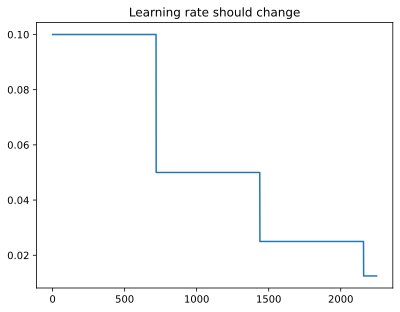

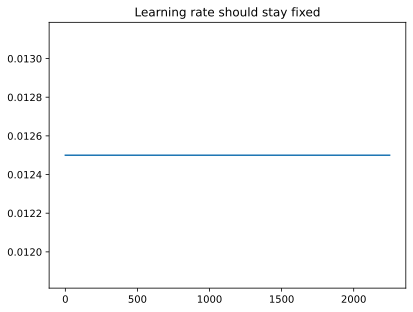

In [17]:
# Test that the learning rate is really working
trainAcc,testAcc,losses,net,currentLR_dy = function2trainTheModel(Model = test_model , 
                                                               lossfunc = test_lossfunc , 
                                                               optimizer = test_optimizer ,
                                                               scheduler = test_scheduler,
                                                               toggleDynamicLR = True ,
                                                               train_loader = train_loader , 
                                                               test_loader = test_loader , 
                                                               epochs = 50 )
plt.plot(currentLR_dy)
plt.title('Learning rate should change')
plt.show()

trainAcc,testAcc,losses,net,currentLR_St = function2trainTheModel(Model = test_model , 
                                                               lossfunc = test_lossfunc , 
                                                               optimizer = test_optimizer ,
                                                               scheduler = test_scheduler,
                                                               toggleDynamicLR = False ,
                                                               train_loader = train_loader , 
                                                               test_loader = test_loader , 
                                                               epochs = 50 )

plt.plot(currentLR_St)
plt.title('Learning rate should stay fixed')
plt.show()

# Explanation of dynamic LR:
# epoch : 0 - 720     : LR = 0.01
# epoch : 721 - 1441  : LR = 0.05
# epoch : 1442 - 2162 : LR = 0.025
# epoch : 2163 - 2250 : LR = 0.0125

## 8. Experiment

#### (i) Testing with Dynamic LR

In [18]:

ANNmodel1 ,lossfunc1 , optimizer1 ,scheduler1 = createQwertyNet_LRDecay(initialLR = 0.1)

trainAccDynamic,testAccDynamic,losses,net,currentLR = function2trainTheModel(Model = ANNmodel1 , 
                                                               lossfunc = lossfunc1 , 
                                                               optimizer = optimizer1 ,
                                                               scheduler = scheduler1,
                                                               toggleDynamicLR = True ,
                                                               train_loader = train_loader , 
                                                               test_loader = test_loader , 
                                                               epochs = 100 )


#### (ii) Testing with Static LR

In [19]:

ANNmodel2 ,lossfunc2 , optimizer2 ,scheduler2 = createQwertyNet_LRDecay(initialLR = 0.1)
trainAccStatic,testAccStatic,losses,net,currentLR   = function2trainTheModel(Model = ANNmodel2 , 
                                                               lossfunc = lossfunc2 , 
                                                               optimizer = optimizer2 ,
                                                               scheduler = scheduler2,
                                                               toggleDynamicLR = False ,
                                                               train_loader = train_loader , 
                                                               test_loader = test_loader , 
                                                               epochs = 100 )

## 9. Results Visualization

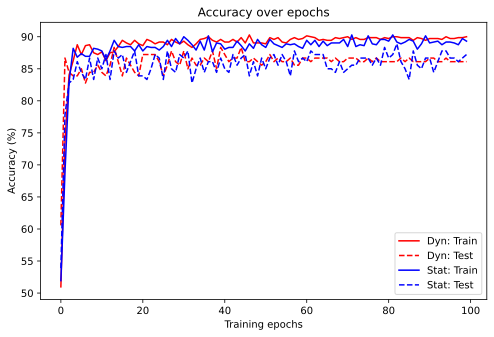

In [20]:
fig = plt.figure(figsize=(8,5))
plt.plot(trainAccDynamic,'r',label='Dyn: Train')
plt.plot(testAccDynamic,'r--',label='Dyn: Test')

plt.plot(trainAccStatic,'b',label='Stat: Train')
plt.plot(testAccStatic,'b--',label='Stat: Test')

plt.xlabel('Training epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over epochs')
plt.legend()

plt.show()